# 4. The Kutta condition

For surfaces that contain convex edges, the vortex sheet strength assumes a singular behavior in the vicinity of these edges, with a strength that depends on the interior angle of the edge: sharper edges have more singular behavior. In the discrete representation of the surface, edges are only approximately represented by the sudden disruptions of positions in clusters of adjacent points. The behavior in this discrete form is not quite singular, but the solution for the vortex sheet strength $\mathfrak{f}$ nonetheless exhibits a large and rapid change of amplitude.

Let's illustrate this with the example of a flat plate. First create the grid.

In [1]:
using GridPotentialFlow
using Plots
Δx = 0.01
Lx = 2.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx);

To create a potential flow model with flat plate, we use the `Plate` constructor from `RigidBodyTools.jl` and transform the body such that its angle of attack is `α`.

In [2]:
c = Lx/2 # chord length
α = -π/6 # angle of attack
plate = Plate(c,4*cellsize(g))
Tr = RigidTransform((0.0,0.0),α)
Tr(plate)
pfb = PotentialFlowBody(plate);
model = VortexModel(g,bodies=[pfb]);

To simulate the plate in a uniform flow, we have to set the `U∞` field of the vortex model to our desired value.

In [3]:
setU∞(model,(1.0,0.0))
sol = solve(model);

By plotting a large number streamlines, we see how the flow accelerates as it tries to make its way around the sharp edges of the flat plate. In the continuous case, the velocity field would be singular at the edges.

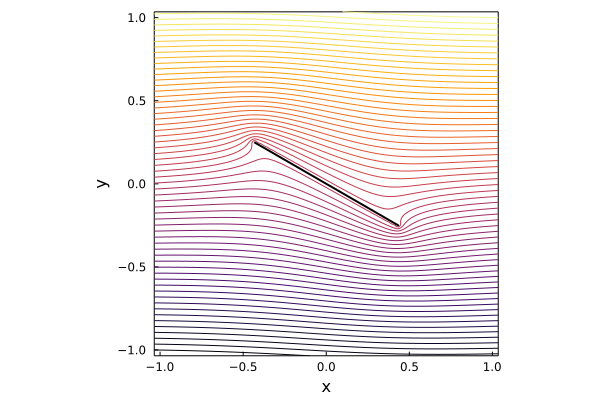

In [4]:
plot(sol.ψ,g,levels=60);
plot!(plate,linecolor=:black,linewidth=2,xlabel="x",ylabel="y")

The continous vortex sheet strength shows similar singularities at the edges, and also in our discrete case, vortex sheet strength the indeed assumes an approximate singular behavior near those edges.

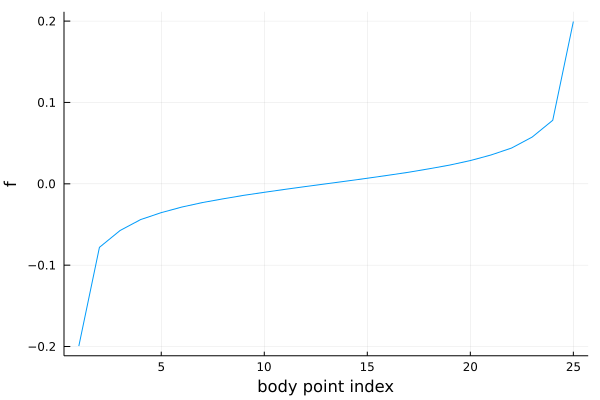

In [5]:
plot(sol.f,xlabel="body point index",ylabel="f",legend=false)

If we seek to eliminate this behavior, we must first have some means of exposing it. In fact, for any discretized surface, the essence of this nearly-singular behavior lies in the previously defined vector $\mathfrak{f}_0$, and all other bound vortex sheets associated with the same surface share the same nearly-singular behavior. Thus, we will use a multiplicative decomposition of the vortex sheet strength:

$\mathfrak{f} = \mathfrak{f}_0 \circ \tilde{\mathfrak{f}}$

where $\circ$ is the Hadamard product. This decomposed form isolates the singular behavior into $\mathfrak{f}_0$, and $\tilde{\mathfrak{f}}$ is a relatively smoother vector of surface point data.

For our flat plate, we create $\mathfrak{f}_0$ in the same way as we did on the previous page.

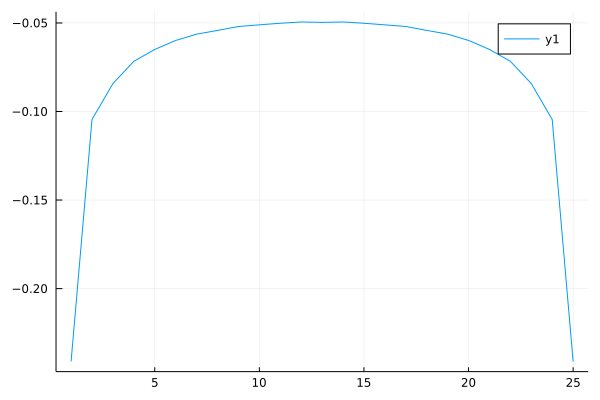

In [6]:
ones = ScalarData(length(plate))
ones .= 1.0
f₀ = model.system.ibp.Sfact\ones
plot(f₀)

Then we can plot the smooth $\tilde{\mathfrak{f}}$ as follows.

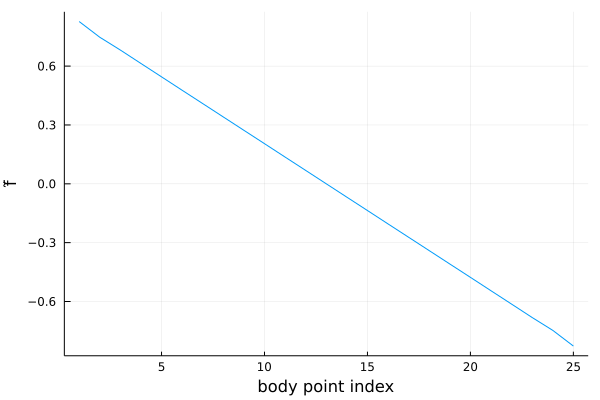

In [7]:
plot(sol.f./f₀,xlabel="body point index",ylabel="f̃",legend=false)

## Using the Kutta condition in a steady-state problem

The Kutta condition corresponds to annihilating the nearly-singular behavior at a surface point. At such points, we will set the corresponding value of $\tilde{\mathfrak{f}}$ to zero. Suppose we wish to enforce the Kutta condition at an edge corresponding to surface point $k$. The condition is

$\mathfrak{e}_{k}^{T} \tilde{\mathfrak{f}} = 0.$

In the regularization operation on $\mathfrak{f}$, we can absorb $\mathfrak{f}_0$ into $\mathsf{R}$, first noting that the Hadamard product can alternatively be written with the help of a diagonal matrix,

$\mathfrak{f} = \mathfrak{f}_0 \circ \tilde{\mathfrak{f}} = \mathsf{D}{\mathfrak{f}_0} \tilde{\mathfrak{f}}.$

Then, we can define a re-scaled regularization operator,

$\mathsf{R}\mathfrak{f} = \mathsf{R} \mathsf{D}{\mathfrak{f}_0} \tilde{\mathfrak{f}} = \tilde{\mathsf{R}} \tilde{\mathfrak{f}}.$

We will first take the steady-state approach to enforce the Kutta condition: allow the bound circulation to be set appropriately, with the implicit understanding that there is a starting vortex of equal and opposite circulation at infinity that preserves the Kelvin circulation theorem. The Lagrange multiplier for this constraint will not be $\Gamma_b$, but $s_0$.

$\begin{bmatrix}
\mathsf{L} & \tilde{\mathsf{R}} & 0\\
\mathsf{E} &  0 & \mathfrak{1}\\
0 & \mathfrak{e}_{k}^{T} & 0\\
\end{bmatrix} \begin{pmatrix} \mathsf{s} \\ \tilde{\mathfrak{f}} \\ s_0 \end{pmatrix} =
\begin{pmatrix} -\mathsf{w} \\ \mathfrak{s}'_b \\ 0 \end{pmatrix}.$

In `GridPotentialFlow.jl`, we create a regularized potential flow model by specifying the index of the regularized edges using the `edges` keyword when creating a `PotentialFlowBody`. In this case, we want to regularize the trailing edge, which is the last point of `Plate`, so its index is `length(plate)`.

In [8]:
pfb = PotentialFlowBody(plate,edges=[length(plate)])
model = VortexModel(g,bodies=[pfb],U∞=(1.0,0.0))
sol = solve(model);

When there are no vortices present in the model, the package solves the above saddle point system and the solution is the steady state solution. Inspection of the streamlines shows that flow now indeed leaves the trailing edge smoothly.

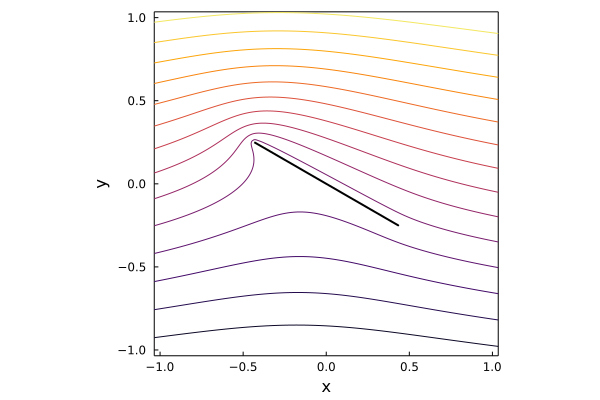

In [9]:
plot(sol.ψ,g);
plot!(plate,linecolor=:black,linewidth=2,xlabel="x",ylabel="y")

By plotting the vortex sheet strength, we can see that by constraining the trailing edge point of $\tilde{\mathfrak{f}}$, its whole distribution is shifted upward compared to the unregularized case such that the last value equals zero.

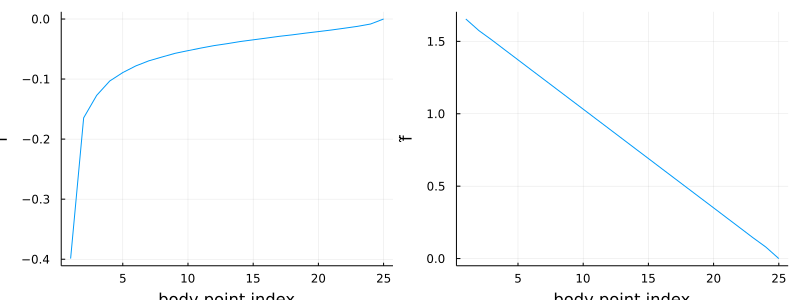

In [10]:
plot(plot(sol.f,xlabel="body point index",ylabel="f",legend=false),plot(sol.f./f₀,xlabel="body point index",ylabel="f̃",legend=false),size=[800,300])

## Using the Kutta condition to set a new vortex element

In the previous section, we used the Kutta condition to set the bound circulation but did not explicitly create a new vortex element. This vortex element was assumed to lie at infinity so that its effect was negligible except insofar as it left equal but opposite circulation about the body.

In this section, we will create a new vortex element in the vicinity of the edge at which we are applying the Kutta condition. We will thus seek to establish the strength of this new element and to do so in such a manner that the overall circulation of the flow is conserved. Once the element is created, it will be allowed to advect with the local fluid velocity (minus its own contribution to this velocity).

Let us assume that the new vortex element (which we label with the subscript 1) is introduced at some point in physical space, and that its immersion into the Cartesian grid is described by a grid vector $\mathsf{d}_1$ and that its strength (i.e., its circulation) is $\delta\Gamma_1$. Thus, the fluid vorticity after this new element's introduction can be written as

$\mathsf{w} + \delta\Gamma_1 \mathsf{d}_1.$

The vector $\mathsf{d}_1$ is the discrete Dirac delta function, identical (or similar) to the function that constitutes the regularization $\mathsf{R}$ and interpolation $\mathsf{E}$ matrices.

The Kutta condition is still to be enforced. We also seek to ensure that the total circulation is zero. (We are assuming that the flow has started from rest.) Let us denote the circulation of the existing fluid vorticity $\mathsf{w}$ by

$\Gamma_{\mathsf{w}} = \Delta x \, \mathsf{1}^{T}\mathsf{w},$

where $\mathsf{1}$ is a grid vector of ones. Then, the circulation constraint is

$\mathfrak{1}^{T} \mathfrak{f} + \delta\Gamma_1 + \Gamma_{\mathsf{w}} = 0.$

The circulation of the bound vortex sheet $\mathfrak{f}$ can be re-written in terms of the smooth part of the sheet as $\mathfrak{1}^{T} \mathfrak{f} = \mathfrak{f}_0 \tilde{\mathfrak{f}}$.

With these two constraints, the overall saddle point system of equations is

$\begin{bmatrix}
\mathsf{L} & \tilde{\mathsf{R}} & 0 & \mathsf{d}_1\\
\mathsf{E} &  0 & \mathfrak{1} & 0\\
0 & \mathfrak{e}_{k}^{T} & 0 & 0\\
0 & \mathfrak{f}_{0}^{T} & 0 & 1
\end{bmatrix} \begin{pmatrix} \mathsf{s} \\ \tilde{\mathfrak{f}} \\ s_0 \\ \delta\Gamma_1 \end{pmatrix} =
\begin{pmatrix} -\mathsf{w} \\ \mathfrak{s}'_b \\ 0 \\ -\Gamma_{\mathsf{w}} \end{pmatrix}.$

To simulate this case for our flat plate, we need to insert a point vortex in the flow, preferably near the trailing edge. This situation corresponds to the flow right after impulsively starting a uniform flow around a flat plate and the point vortex now represents the starting vortex. We position the vortex behind and orthogonal the plate at a distance that is proportional to the convective length from the trailing edge. This position does not matter much here, but is of importance when we step in time and insert more point vortices every time step. Its strength can be set arbitrarily, because any vortices that are used for regularizing edges will be ignored when calculating $\mathsf{w}$ in the right-hand side for the saddle-point system.

In [11]:
Δt = 1e-2
vTE = Vortex(plate.x[end]+3*Δt*cos(α+π/2),plate.y[end]+3*Δt*sin(α+π/2),0.0);

We include the point vortex when we create our model. Because the package detects that there is a vortex in the model, it solves the unsteady saddle point system and the solution will include the strength for the new point vortex.

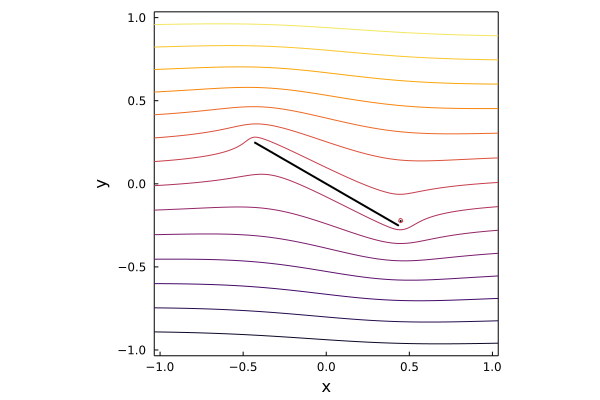

In [12]:
pfb = PotentialFlowBody(plate,edges=[length(plate)])
model = VortexModel(g,bodies=[pfb],vortices=[vTE],U∞=(1.0,0.0))
sol = solve(model);
plot(sol.ψ,g);
plot!(plate,linecolor=:black,linewidth=2)
scatter!(model.vortices.x,model.vortices.y,color=:black,markersize=2,xlabel="x",ylabel="y")

Note that the strength of the new point vortex is not automatically set when calling `solve` on the vortex model

Because of the proximity of the point vortex to the flat plate, $\tilde{\mathfrak{f}}$ exhibits a quick variation in its value at the surface points that lie closest to the point vortex. The value at the trailing edge point itself is still constrained to zero.

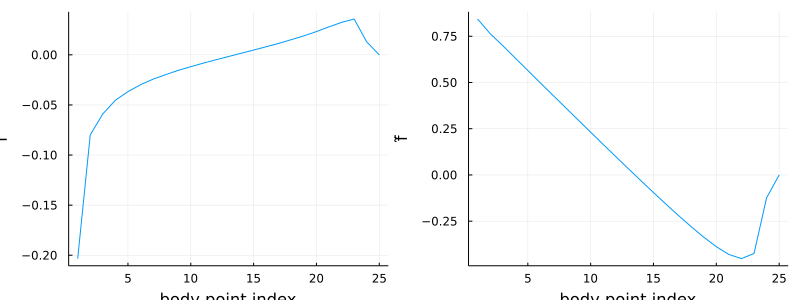

In [13]:
plot(plot(sol.f,xlabel="body point index",ylabel="f",legend=false),plot(sol.f./f₀,xlabel="body point index",ylabel="f̃",legend=false),size=[800,300])

## Applying more than one Kutta condition on a body

Suppose we wish to enforce the Kutta condition at two edges of the body---at points $k_{1}$ and $k_{2}$---instead of one. Each such point has a constraint,

$\mathfrak{e}_{k_j}^{T} \tilde{\mathfrak{f}} = 0,\quad j = 1,2.$

For two such constraints, we need two Lagrange multipliers: the strengths of two new vortices, $\delta\Gamma_1$ and $\delta\Gamma_2$, immersed into the grid with $\mathsf{d}_1$ and $\mathsf{d}_2$, respectively; and we still need the Lagrange multiplier $s_0$ to ensure that Kelvin's circulation theorem is also enforced. The system in the previous section is thus easily generalized to the following:

$\begin{bmatrix}
\mathsf{L} & \tilde{\mathsf{R}} & 0 & \mathsf{d}_1 & \mathsf{d}_2\\
\mathsf{E} &  0 & \mathfrak{1} & 0& 0\\
0 & \mathfrak{e}_{k_1}^{T} & 0 & 0 & 0\\
0 & \mathfrak{e}_{k_2}^{T} & 0 & 0 & 0\\
0 & \mathfrak{f}_{0}^{T} & 0 & 1 & 1
\end{bmatrix} \begin{pmatrix} \mathsf{s} \\ \tilde{\mathfrak{f}} \\ s_0 \\ \delta\Gamma_1 \\ \delta\Gamma_2 \end{pmatrix} =
\begin{pmatrix} -\mathsf{w} \\ \mathfrak{s}'_b \\ 0 \\ 0 \\ -\Gamma_{\mathsf{w}} \end{pmatrix}.$

We now simulate this case again for our flat plate problem. This solution corresponds to the flow right after impulsively starting a uniform flow around a flat plate, but unlike the previous case, the flow now also separates at the leading edge.

We create two vortices, one near the leading edge and one near the trailing edge.

In [14]:
vLE = Vortex(plate.x[1]+3*Δt*plate.len*cos(plate.α+π/2),plate.y[1]+3*Δt*plate.len*sin(plate.α+π/2),0.0);
vTE = Vortex(plate.x[end]+3*Δt*cos(α+π/2),plate.y[end]+3*Δt*sin(α+π/2),0.0);

The model now has two regularized edges, corresponding to the first body point and the last one.

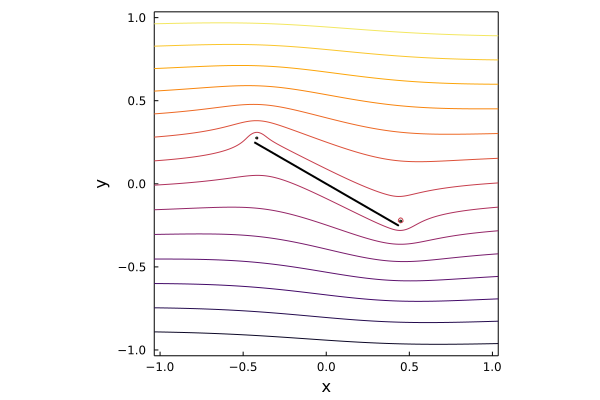

In [15]:
pfb = PotentialFlowBody(plate,edges=[1,length(plate)])
model = VortexModel(g,bodies=[pfb],vortices=[vLE,vTE],U∞=(1.0,0.0))
sol = solve(model);
plot(sol.ψ,g);
plot!(plate,linecolor=:black,linewidth=2)
scatter!(model.vortices.x,model.vortices.y,markersize=2,xlabel="x",ylabel="y")

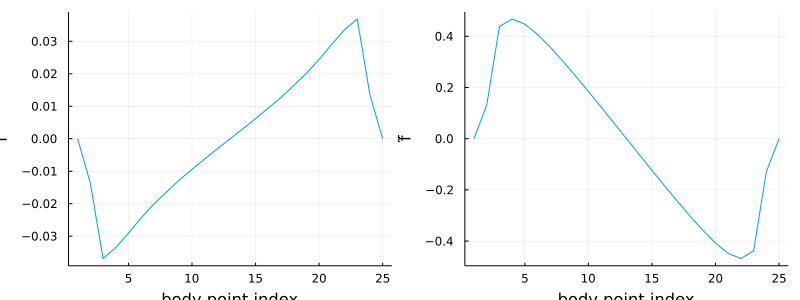

In [16]:
plot(plot(sol.f,xlabel="body point index",ylabel="f",legend=false),plot(sol.f./f₀,xlabel="body point index",ylabel="f̃",legend=false),size=[800,300])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*